In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from string import punctuation 
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/lazy-af-7/twitter_airline_nlp/main/Train.csv')
df.head()

,Unnamed: 0,tweet_id,airline_sentiment,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,0,569612379811676161,negative,US Airways,NaN,09202010,NaN,0,@USAirways US Airlines 699 LA to RDU is holdin...,NaN,2015-02-22 13:39:08 -0800,NaN,Mountain Time (US & Canada)
1,1,570283248301043712,negative,Southwest,NaN,slobotski,NaN,0,@SouthwestAir went to purchase a flight that I...,NaN,2015-02-24 10:04:56 -0800,Midwest + Airplanes,Central Time (US & Canada)
2,2,569684565838553088,negative,American,NaN,61jr,NaN,0,@AmericanAir their flights into Buffalo as wel...,NaN,2015-02-22 18:25:59 -0800,St. Catharines,NaN
3,3,569313126342123520,negative,US Airways,NaN,iZoom23,NaN,0,@USAirways Sitting in a cesspool of germs on t...,NaN,2015-02-21 17:50:01 -0800,New York,Eastern Time (US & Canada)
4,4,569723892358467584,negative,United,NaN,ljtypes,NaN,0,@united you advertise the flight and its still...,NaN,2015-02-22 21:02:15 -0800,H-town,NaN


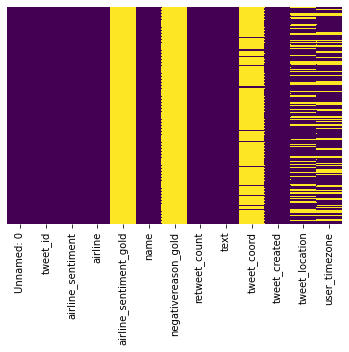

In [3]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

In [4]:
df=df[['text','airline_sentiment']]
df.head()

,text,airline_sentiment
0,@USAirways US Airlines 699 LA to RDU is holdin...,negative
1,@SouthwestAir went to purchase a flight that I...,negative
2,@AmericanAir their flights into Buffalo as wel...,negative
3,@USAirways Sitting in a cesspool of germs on t...,negative
4,@united you advertise the flight and its still...,negative


In [5]:
df['text']=df['text'].apply(lambda x: x.lower())
df.head()

,text,airline_sentiment
0,@usairways us airlines 699 la to rdu is holdin...,negative
1,@southwestair went to purchase a flight that i...,negative
2,@americanair their flights into buffalo as wel...,negative
3,@usairways sitting in a cesspool of germs on t...,negative
4,@united you advertise the flight and its still...,negative


In [6]:
df['text']=df['text'].apply(lambda x: ''.join([c for c in x if c not in punctuation]))
df.head()

,text,airline_sentiment
0,usairways us airlines 699 la to rdu is holding...,negative
1,southwestair went to purchase a flight that i ...,negative
2,americanair their flights into buffalo as well...,negative
3,usairways sitting in a cesspool of germs on th...,negative
4,united you advertise the flight and its still ...,negative


In [7]:
df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

,text,airline_sentiment
0,usairways us airlines 699 la to rdu is holding...,negative
1,southwestair went to purchase a flight that i ...,negative
2,americanair their flights into buffalo as well...,negative
3,usairways sitting in a cesspool of germs on th...,negative
4,united you advertise the flight and its still ...,negative
...,...,...
7681,usairways i promise if i can help it i will nv...,negative
7682,usairways reminder from 228 well be tweeting f...,neutral
7683,usairways flight 1898 landed over 2 hours ago ...,negative
7684,united alright thank you much appreciated,positive


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


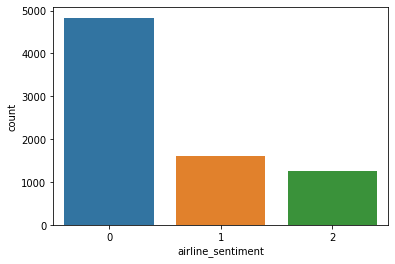

In [8]:
le = LabelEncoder()
df['airline_sentiment']=le.fit_transform(df['airline_sentiment'])
sns.countplot('airline_sentiment',data=df)
plt.show()

In [9]:
sentences=df['text'].tolist()
labels=df['airline_sentiment'].tolist()

In [10]:
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0: training_size]
testing_senteces = sentences[: training_size]
training_labels = labels[0: training_size]
testing_labels = labels[: training_size]

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
vocab_size = 1000
embedding_dim = 16
max_length = 280
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_senteces)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(embedding_dim,
                         return_sequences=True)
))
model.add(tf.keras.layers.Dense(6, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [14]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(0.01),metrics=['accuracy'])

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',baseline=None, restore_best_weights=False)
num_epochs=10
modelo = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final),callbacks=[callbacks],batch_size=16)

Epoch 1/10
385/385 [==============================] - 60s 155ms/step - loss: -0.5933 - accuracy: 0.6736 - val_loss: -0.9074 - val_accuracy: 0.6914
Epoch 2/10
385/385 [==============================] - 59s 153ms/step - loss: -0.4092 - accuracy: 0.6659 - val_loss: -0.9484 - val_accuracy: 0.6967
Epoch 3/10
385/385 [==============================] - 59s 153ms/step - loss: -0.8135 - accuracy: 0.6915 - val_loss: -1.0507 - val_accuracy: 0.7059
Epoch 4/10
187/385 [=============>................] - ETA: 26s - loss: -1.0416 - accuracy: 0.7053